In [1]:
%load_ext autoreload
%autoreload 2

This document gives a tutorial to use ML predictions and uncertainty quantification for "smart tracking" of modes.

In [10]:
# Import the necessary libraries

#global imports
import numpy as np
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor


import dotenv
dotenv.load_dotenv(override=True)

#local imports
from src.data.make_dataset import create_input_target_dataset
from src.data.utils import get_input_data
from src.data.make_dataset import create_input_target_dataset
from src.smart_tracking.smart_tracking import smart_tracking

In [8]:
# Gather the data used in this tutorial

# location of the data (store data location in environment variable)
package_folder = os.getenv('PACKAGE_FOLDER')
data_folder = os.path.join(package_folder, 'data') # Replace by folder containing data if necessary

# Depending on how your data is stored, you may need to adjust the following lines
location = 'nw2'
turbine = 'c02'
mode = 'SS2'

# Get the input data for the model
data = get_input_data(data_folder, location, turbine)

# Get the selected data used to propagate the uncertainty
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))

In [9]:
#Columns were selected using RFECV

selected_columns = [
        'mean_NW2_C02_rpm',
        'mean_NW2_C02_pitch', 
        'mean_NW2_C02_power',
        'mean_NW2_C02_windspeed',
        'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
        'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection',
        'mvbc_WandelaarBuoy_Wave_height',
        #'mvbc_WandelaarBuoy_Average_wave_period',
        'mvbc_WandelaarMeasuringpile_Tide_TAW',
        #'mvbc_WandelaarMeasuringpile_Air_pressure',
        #'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

In [12]:
# Create the training and testing datasets
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

# Remove the selected data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

# Create training dataset based on the selected data
y_train = selected_data_unique[['mean_frequency']].set_index(selected_data_unique['timestamp'])
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.loc[y_train.index.intersection(X.index)]
X_train = X.loc[y_train.index]
X_train = X_train[selected_columns]

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [13]:
# Prepare and train the model: Hyperparameters can be optimized manually through trial and error or automatically using hyperopt (Bayesian Hyperparameter Optimization)
regr_model = CatBoostRegressor(
    iterations=1000,
    depth=3,
    learning_rate=0.5,
    random_seed=13,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

regr_model.fit(X_train, y_train)

In [14]:
# Make predictions using the model

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


In [15]:
# Find the uncertainty limit and the prediction limit for the smart tracking methodology
# Uncretainty limit is based on the 99 percentile of the moving average uncertainty on 6 hours
# while the prediction limit is 2 standard deviations of the residuals

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.99)

prediction_lim = (y - predictions_df['prediction']).loc[X_train.index].std()*2

In [16]:
# Smart track the modes
smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)

# Save the results in a dataframe
predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y - predictions_df['prediction']

# Analyze the results on a short timeframe

Showing original modes and tracked modes and the uncertainty

C:\Users\Max\AppData\Local\Temp\ipykernel_24436\3610912892.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
C:\Users\Max\AppData\Local\Temp\ipykernel_24436\3610912892.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_24436\3610912892.py:56: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend2.legendHandles:


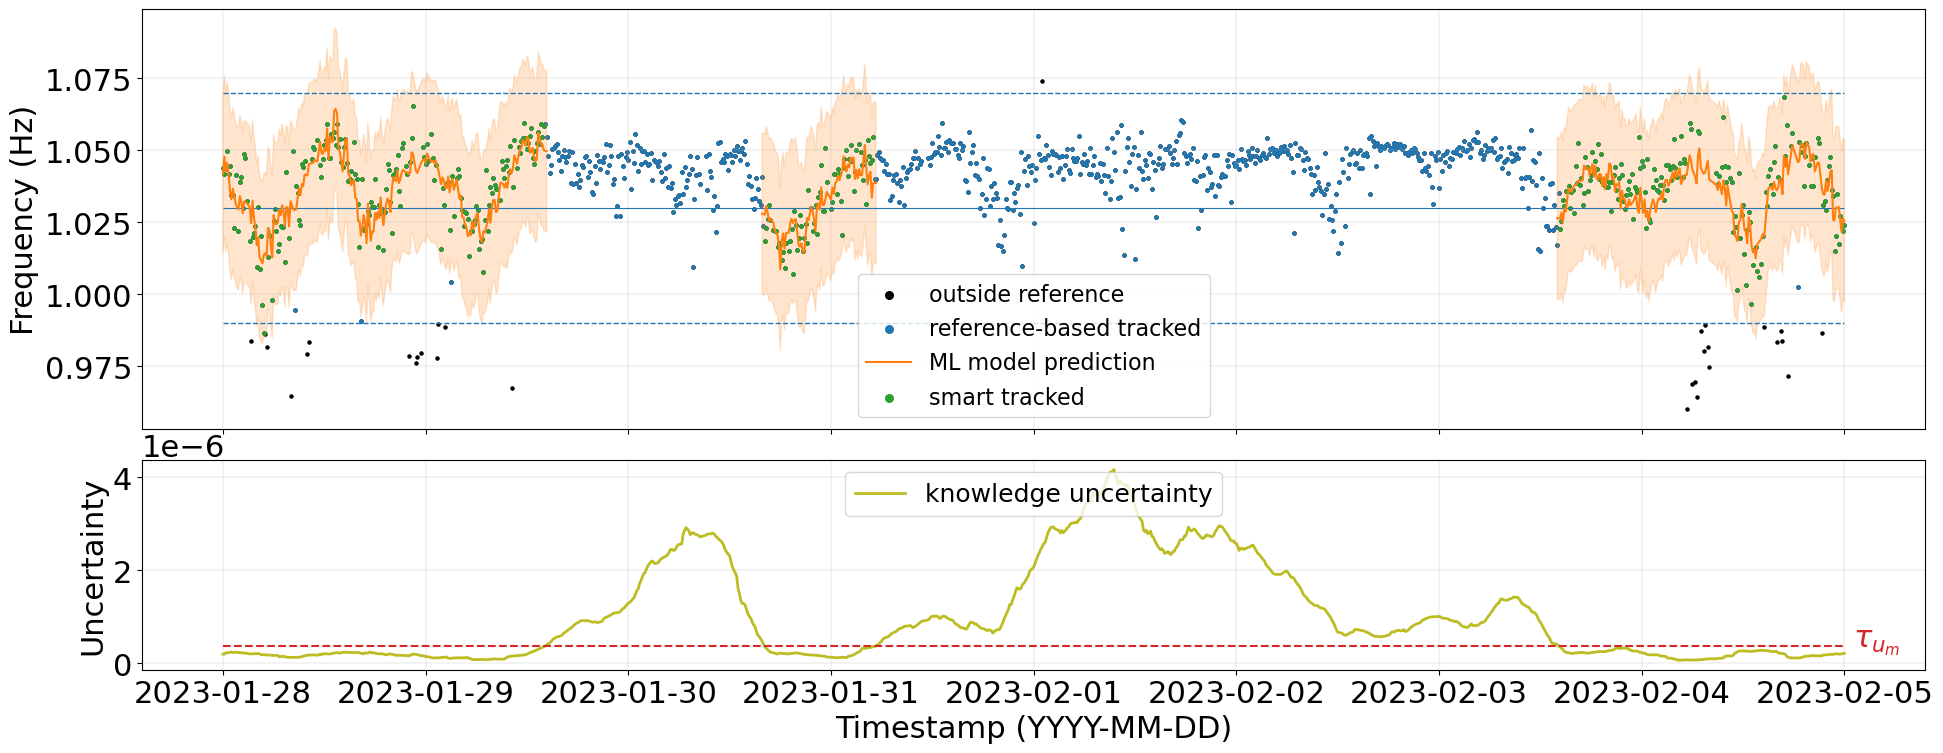

In [21]:
analyzed_timeframe = (
    datetime.datetime(2023, 1, 28, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 2, 5, tzinfo=datetime.timezone.utc)
)

plt_selected_input_data = X.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_modal_data = y.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
plt_predictions = predictions_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]
low_uncertainty = uncertainty_[uncertainty_moving_avg < uncertainty_lim].index
common_indices = plt_predictions.index.intersection(low_uncertainty)
plt_predictions_low_uncertainty = plt_predictions.loc[common_indices]
resampled_plt_predictions = plt_predictions_low_uncertainty.resample('10T').asfreq()['prediction']
resampled_plt_predictions.interpolate(method='linear', inplace=True, limit_direction='both', limit=2)
plt_smart_tracked = smart_tracked_modes.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]

upper_ref = 1.07
lower_ref = 0.99
reference_tracked = plt_modal_data[(plt_modal_data > lower_ref) & (plt_modal_data < upper_ref)]
plt.rcParams['font.size'] = 22

# Create a figure with two subplots (axes), one under the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), 
                               gridspec_kw={'height_ratios': [2, 1]})


# First plot (modal data and predictions)
ax1.scatter(plt_modal_data.index, plt_modal_data, color='k', s=5, label='outside reference')
ax1.hlines(upper_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=1, linestyle='--')
ax1.hlines(lower_ref, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=1, linestyle='--')
ax1.hlines((lower_ref+upper_ref)/2 , analyzed_timeframe[0], analyzed_timeframe[1], color='tab:blue', linewidth=0.8)
ax1.scatter(reference_tracked.index, reference_tracked, color='tab:blue', s=5, label='reference-based tracked')
ax1.plot(resampled_plt_predictions, color='tab:orange', label='ML model prediction')
ax1.fill_between(resampled_plt_predictions.index, resampled_plt_predictions-prediction_lim, resampled_plt_predictions+prediction_lim, alpha=0.2, color='tab:orange')
ax1.scatter(plt_smart_tracked.index, plt_smart_tracked['frequency'], color='tab:green', s=5, label='smart tracked')

ax1.tick_params(axis='x', labelsize=16)
ax1.grid(linewidth=0.2)
ax1.set_ylabel('Frequency (Hz)')
legend1 = ax1.legend(loc='lower center', fontsize=16)
for handles in legend1.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
ax1.set_xticklabels([])  # This will remove the x-axis values
# Second plot (uncertainty)
ax2.plot(uncertainty_moving_avg.loc[analyzed_timeframe[0]:analyzed_timeframe[1]], color='tab:olive', label='knowledge uncertainty', linewidth = 2)
ax2.hlines(uncertainty_lim, analyzed_timeframe[0], analyzed_timeframe[1], color='tab:red', linestyles='--')
#ax2.scatter(virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]].index, virtual_ensemble_preds_df.loc[analyzed_timeframe[0]:analyzed_timeframe[1]]['knowledge uncertainty'], s=1, c='tab:blue')
ax2.text(analyzed_timeframe[1]+datetime.timedelta(hours=1), uncertainty_lim, r'$\tau_{u_{m}}$', color='tab:red')
ax2.grid(linewidth=0.2)
ax2.set_ylabel('Uncertainty')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

legend2 = ax2.legend(loc='upper center', fontsize=18)
for handles in legend2.legendHandles:
    try:
        handles.set_sizes([30.0])
    except:
        pass
# Adjust layout and show the combined figure
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.show()
